# Análisis exploratorio de datos - **Comentarios Youtube**

### Importar librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Descargar recursos de NLTK si es necesario
try:
    stopwords.words('english')
except:
    nltk.download('stopwords')
    nltk.download('punkt')

## 1 . CARGA E INSPECCIÓN INICIAL DE DATOS

In [2]:
df = pd.read_csv('../data/youtoxic_english_1000.csv')

print("📊 INFORMACIÓN BÁSICA DEL DATASET")
print("="*50)
print(f"Dimensiones: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print("\n📋 Columnas disponibles:")
print(df.columns.tolist())

📊 INFORMACIÓN BÁSICA DEL DATASET
Dimensiones: (1000, 15)
Número de filas: 1000
Número de columnas: 15

📋 Columnas disponibles:
['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']


##  2. ESTRUCTURA Y CALIDAD DE DATOS

In [3]:
print("🔍 INFORMACIÓN DETALLADA")
print("="*30)
print(df.info())
print("\n🎯 PRIMERAS 5 FILAS:")
df.head()

🔍 INFORMACIÓN DETALLADA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsHatespeech     1000 non-null   bool  
 9   IsRacist         1000 non-null   bool  
 10  IsNationalist    1000 non-null   bool  
 11  IsSexist         1000 non-null   bool  
 12  IsHomophobic     1000 non-null   bool  
 13  IsReligiousHate  1000 non-null   bool  
 14  IsRadicalism     1000 non-null   bool  
dtypes: bool(12), object(3)
memory usage: 35.3+ KB
None

🎯 PRIMERAS 5 FILAS:


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


## 3. ANÁLISIS DE VALORES FALTANTES

### 3.1 VALORES FALTANTES

In [4]:
print("❌ VALORES FALTANTES")
print("="*25)
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_data.index,
    'Valores Faltantes': missing_data.values,
    'Porcentaje': missing_percentage.values
})
print(missing_df[missing_df['Valores Faltantes'] > 0])

# Visualización de valores faltantes
if missing_data.sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Mapa de Valores Faltantes')
    plt.show()

❌ VALORES FALTANTES
Empty DataFrame
Columns: [Columna, Valores Faltantes, Porcentaje]
Index: []


### 3.2 LIMPIEZA Y PREPROCESAMIENTO DE TEXTO

In [6]:
import string
import emoji

print("🧹 ANÁLISIS Y LIMPIEZA DEL TEXTO")
print("="*35)

# Función de limpieza completa
def analyze_text_characteristics(texts):
    """Analiza características del texto antes de limpieza"""
    stats = {
        'urls': sum(1 for text in texts if 'http' in str(text) or 'www.' in str(text)),
        'mentions': sum(1 for text in texts if '@' in str(text)),
        'hashtags': sum(1 for text in texts if '#' in str(text)),
        'emojis': sum(1 for text in texts if emoji.demojize(str(text)) != str(text)),
        'numbers': sum(1 for text in texts if any(char.isdigit() for char in str(text))),
        'special_chars': sum(1 for text in texts if any(char in string.punctuation for char in str(text))),
        'all_caps_words': sum(len([word for word in str(text).split() if word.isupper() and len(word) > 1]) for text in texts)
    }
    return stats

🧹 ANÁLISIS Y LIMPIEZA DEL TEXTO


In [8]:
# Analizar características del texto crudo
print("📊 CARACTERÍSTICAS DEL TEXTO CRUDO:")
text_chars = analyze_text_characteristics(df['Text'])
for key, value in text_chars.items():
    percentage = (value / len(df)) * 100
    print(f"  {key}: {value} comentarios ({percentage:.1f}%)")

# Ejemplos de texto problemático
print("\n🔍 EJEMPLOS DE TEXTO PROBLEMÁTICO:")
print("URLs:")
url_examples = df[df['Text'].str.contains('http|www\.', na=False)]['Text'].head(2)
for i, text in enumerate(url_examples, 1):
    print(f"  {i}. {text[:100]}...")

print("\nEmojis/Símbolos especiales:")
special_examples = df[df['Text'].str.contains('[^\w\s]', regex=True, na=False)]['Text'].head(2)
for i, text in enumerate(special_examples, 1):
    print(f"  {i}. {text[:100]}...")


📊 CARACTERÍSTICAS DEL TEXTO CRUDO:
  urls: 12 comentarios (1.2%)
  mentions: 6 comentarios (0.6%)
  hashtags: 10 comentarios (1.0%)
  emojis: 8 comentarios (0.8%)
  numbers: 146 comentarios (14.6%)
  special_chars: 862 comentarios (86.2%)
  all_caps_words: 794 comentarios (79.4%)

🔍 EJEMPLOS DE TEXTO PROBLEMÁTICO:
URLs:
  1. here people his facebook is https://www.facebook.com/bassem.masri.520 he has ties with isis and othe...
  2. I made a song addressing Ferguson and the issues today. Please listen and thank you

Tha Bigger Pict...

Emojis/Símbolos especiales:
  1. If only people would just take a step back and not make this case about them, because it wasn't abou...
  2. Law enforcement is not trained to shoot to apprehend.  They are trained to shoot to kill.  And I tha...


In [10]:
def clean_text(text):
    """Función de limpieza completa de texto"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # 1. Convertir a minúsculas
    text = text.lower()
    
    # 2. Remover URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remover menciones (@usuario)
    text = re.sub(r'@\w+', '', text)
    
    # 4. Remover hashtags pero conservar texto
    text = re.sub(r'#', '', text)
    
    # 5. Convertir emojis a texto (opcional - puedes comentar si quieres mantener emojis)
    text = emoji.demojize(text, delimiters=(" ", " "))
    
    # 6. Remover caracteres especiales pero mantener espacios y puntuación básica
    text = re.sub(r'[^\w\s.!?]', '', text)
    
    # 7. Remover múltiples espacios
    text = re.sub(r'\s+', ' ', text)
    
    # 8. Remover espacios al inicio y final
    text = text.strip()
    
    return text

# Aplicar limpieza
print("\n🧽 APLICANDO LIMPIEZA...")
df['Text_Clean'] = df['Text'].apply(clean_text)


# Comparar antes y después
print("📊 COMPARACIÓN ANTES/DESPUÉS DE LIMPIEZA:")
comparison_stats = pd.DataFrame({
    'Original': [df['Text'].str.len().mean(), df['Text'].str.split().str.len().mean()],
    'Limpio': [df['Text_Clean'].str.len().mean(), df['Text_Clean'].str.split().str.len().mean()]
}, index=['Longitud promedio', 'Palabras promedio'])
print(comparison_stats)

# Ejemplos de limpieza
print("\n🔄 EJEMPLOS DE TRANSFORMACIÓN:")
for i in range(3):
    if i < len(df):
        print(f"\nEjemplo {i+1}:")
        print(f"ORIGINAL: {df['Text'].iloc[i][:150]}...")
        print(f"LIMPIO:   {df['Text_Clean'].iloc[i][:150]}...")


🧽 APLICANDO LIMPIEZA...
📊 COMPARACIÓN ANTES/DESPUÉS DE LIMPIEZA:
                   Original   Limpio
Longitud promedio   185.554  181.502
Palabras promedio    33.776   33.623

🔄 EJEMPLOS DE TRANSFORMACIÓN:

Ejemplo 1:
ORIGINAL: If only people would just take a step back and not make this case about them, because it wasn't about anyone except the two people in that situation. ...
LIMPIO:   if only people would just take a step back and not make this case about them because it wasnt about anyone except the two people in that situation. to...

Ejemplo 2:
ORIGINAL: Law enforcement is not trained to shoot to apprehend.  They are trained to shoot to kill.  And I thank Wilson for killing that punk bitch....
LIMPIO:   law enforcement is not trained to shoot to apprehend. they are trained to shoot to kill. and i thank wilson for killing that punk bitch....

Ejemplo 3:
ORIGINAL: 
Dont you reckon them 'black lives matter' banners being held by white cunts is  kinda patronizing and ironically ra

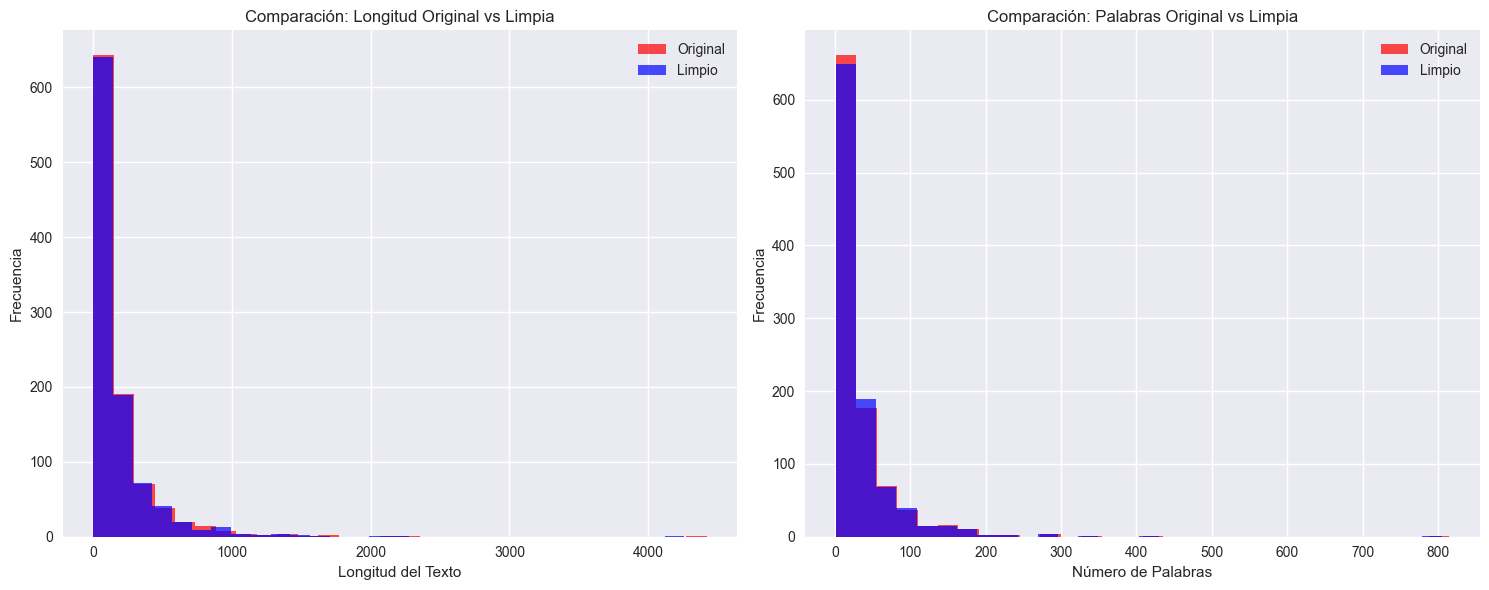

In [12]:
# Calcular métricas de texto original (que faltaban)
df['text_length'] = df['Text'].str.len()
df['word_count'] = df['Text'].str.split().str.len()

# Actualizar métricas con texto limpio
df['clean_text_length'] = df['Text_Clean'].str.len()
df['clean_word_count'] = df['Text_Clean'].str.split().str.len()

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Longitud del texto
axes[0].hist(df['text_length'], alpha=0.7, label='Original', bins=30, color='red')
axes[0].hist(df['clean_text_length'], alpha=0.7, label='Limpio', bins=30, color='blue')
axes[0].set_xlabel('Longitud del Texto')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Comparación: Longitud Original vs Limpia')
axes[0].legend()

# Número de palabras
axes[1].hist(df['word_count'], alpha=0.7, label='Original', bins=30, color='red')
axes[1].hist(df['clean_word_count'], alpha=0.7, label='Limpio', bins=30, color='blue')
axes[1].set_xlabel('Número de Palabras')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Comparación: Palabras Original vs Limpia')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. ANÁLISIS DE VARIABLES OBJETIVO (TOXICIDAD)

🎯 DISTRIBUCIÓN DE TIPOS DE TOXICIDAD
IsToxic            462
IsAbusive          353
IsProvocative      161
IsHatespeech       138
IsRacist           125
IsObscene          100
IsThreat            21
IsReligiousHate     12
IsNationalist        8
IsSexist             1
IsHomophobic         0
IsRadicalism         0
dtype: int64


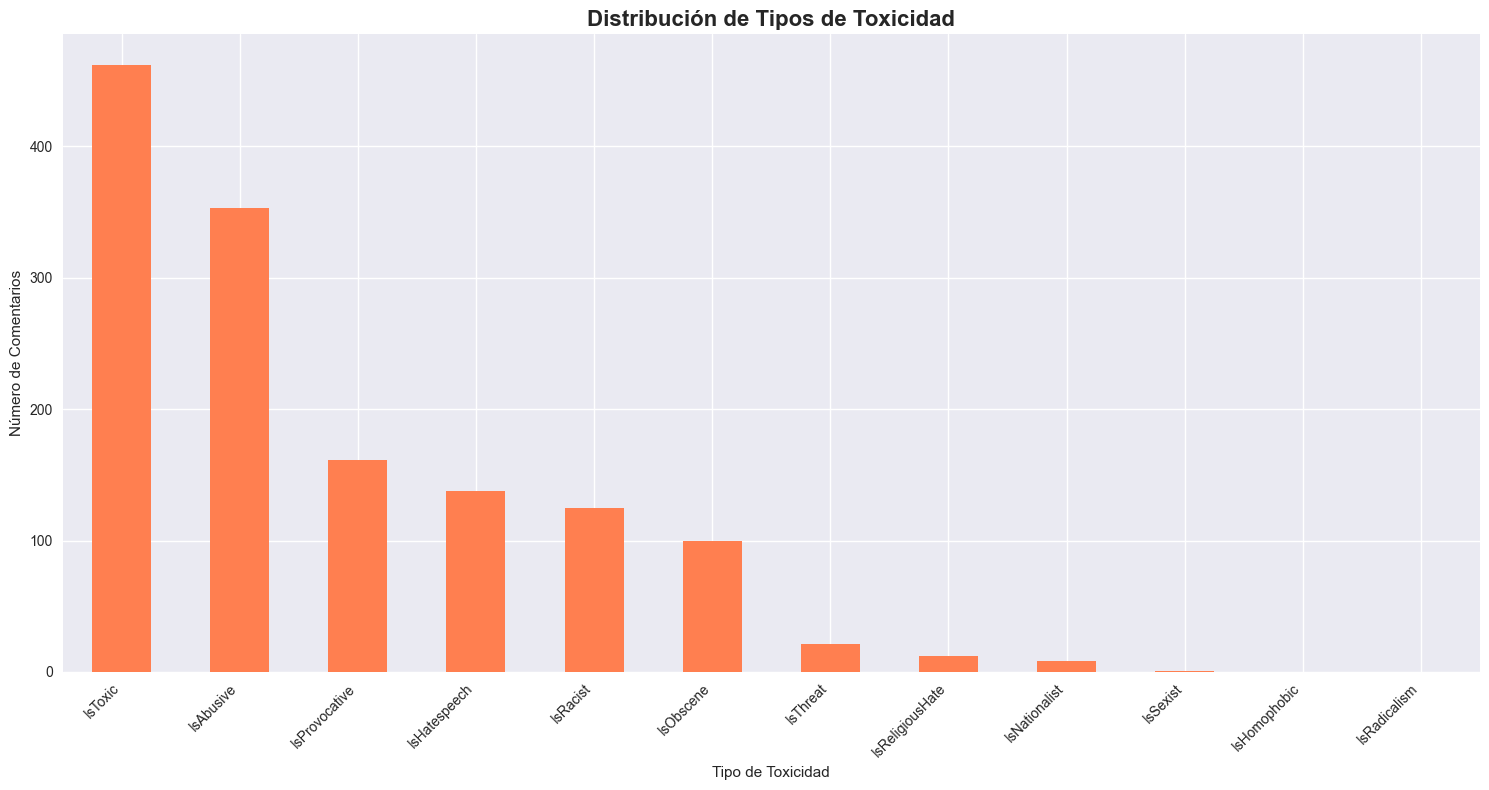

In [13]:
toxicity_columns = ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 
                   'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 
                   'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']

print("🎯 DISTRIBUCIÓN DE TIPOS DE TOXICIDAD")
print("="*40)
toxicity_counts = df[toxicity_columns].sum().sort_values(ascending=False)
print(toxicity_counts)

# Gráfico de barras
plt.figure(figsize=(15, 8))
toxicity_counts.plot(kind='bar', color='coral')
plt.title('Distribución de Tipos de Toxicidad', fontsize=16, fontweight='bold')
plt.xlabel('Tipo de Toxicidad')
plt.ylabel('Número de Comentarios')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()